In [24]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [25]:
from dataset import *
random_state = 1
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = get_bike_share(random_state)

## Compare with EBM

In [3]:
from interpret.glassbox import ExplainableBoostingRegressor

clf = ExplainableBoostingRegressor(interactions=10, feature_names=list(meta_info.keys())[:-1])
clf.fit(train_x, train_y)

pred_train = clf.predict(train_x)
pred_test = clf.predict(test_x)
ebm_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(ebm_stat)

[83.09317 85.30501]


In [4]:
from ebm_module.expapi import EBMExplainer
exp = EBMExplainer(clf)
exp.fit(train_x)

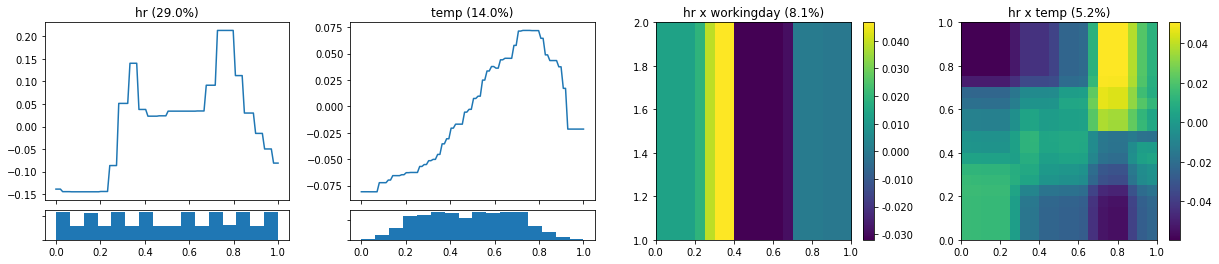

In [23]:
exp.show_global_explain(main_effect_num=2, interaction_num=2)

## Train GAMI-Net 

In [7]:
from gaminet import GAMINetRegressor
model = GAMINetRegressor(interact_num=10,
                         meta_info=meta_info,
                         subnet_size_main_effect=(20, ),
                         subnet_size_interaction=(20, 20), 
                         max_epochs=(1000, 1000, 1000),
                         learning_rates=(0.001, 0.001, 0.0001),
                         early_stop_thres=("auto", "auto", "auto"),
                         warm_start=True,
                         random_state=random_state)
model.fit(train_x, train_y)

/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GAMINetRegressor(meta_info={'cnt': {'scaler': MinMaxScaler(), 'type': 'target'},
                            'hr': {'scaler': MinMaxScaler(),
                                   'type': 'continuous'},
                            'hum': {'scaler': MinMaxScaler(),
                                    'type': 'continuous'},
                            'mnth': {'type': 'categorical',
                                     'values': ['1', '2', '3', '4', '5', '6',
                                                '7', '8', '9', '10', '11',
                                                '12']},
                            'season': {'type': 'categorical',
                                       'values': ['1', '2', '3', '4']},
                            'temp': {'scaler': MinMaxScaler(),
                                     'type': 'continuous'},
                            'weathersit': {'type': 'categorical',
                                           'values': ['1', '2', '3', '4']},
           

In [8]:
model.time_cost_

[('fit_interaction', 7.07),
 ('fine_tune_all', 6.61),
 ('warm_start_interaction', 5.01),
 ('fit_main_effect', 3.65),
 ('warm_start_main_effect', 2.11),
 ('prune_interaction', 0.17),
 ('prune_main_effect', 0.12),
 ('add_interaction', 0.11),
 ('get_interaction_list', 0.07)]

In [9]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x) 

gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[70.39876 73.16486]


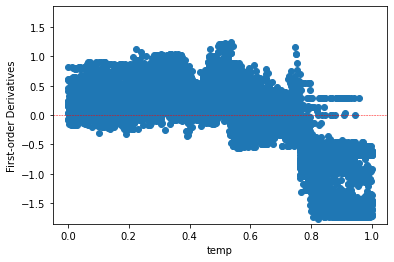

In [10]:
model.partial_derivatives(6)

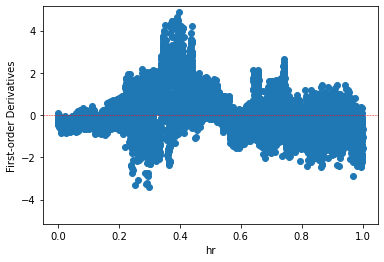

In [11]:
model.partial_derivatives(2)

In [12]:
model.get_mono_loss(train_x), model.certify_mono(n_samples=10000)

(0.0, True)

In [13]:
model.get_clarity_loss(test_x)

0.0005475343205034733

## Visualization

### Training details

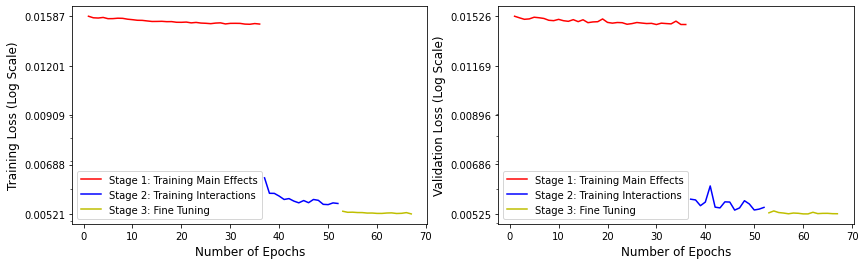

In [14]:
model.show_loss_trajectory()

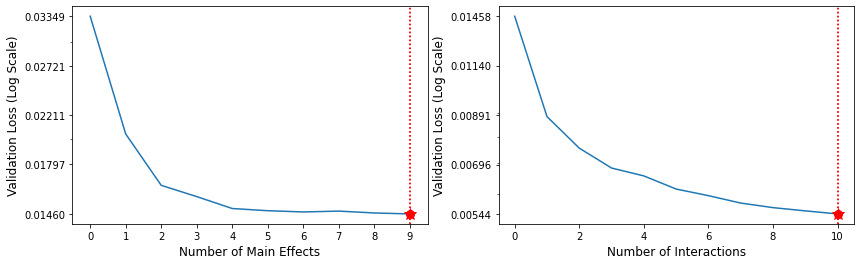

In [15]:
model.show_regularization_path()

### Global explaination

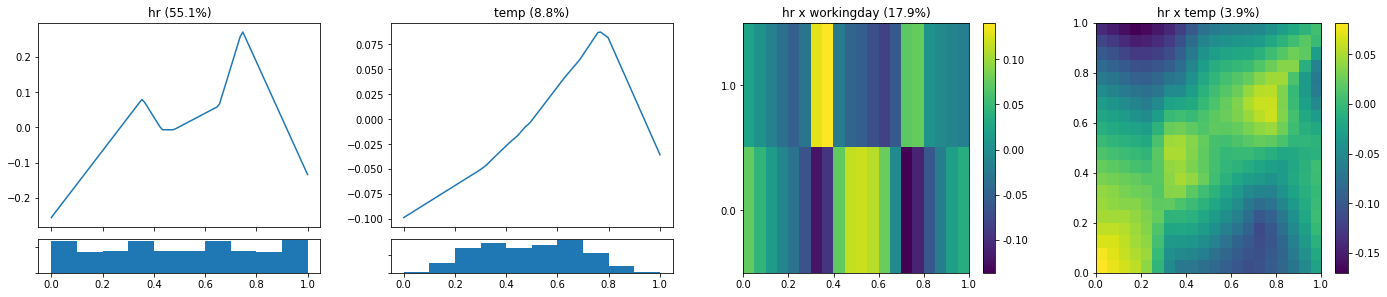

In [22]:
# show all effects 
model.show_global_explain(main_effect_num=2, interaction_num=2)

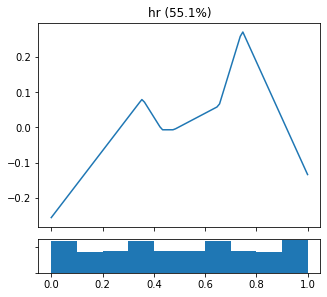

In [17]:
# show one specific effect
model.show_global_explain(key="hr")

### Feature and effect importance

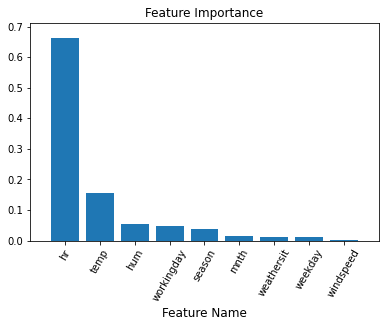

In [18]:
## feature importance 
model.show_feature_importance()

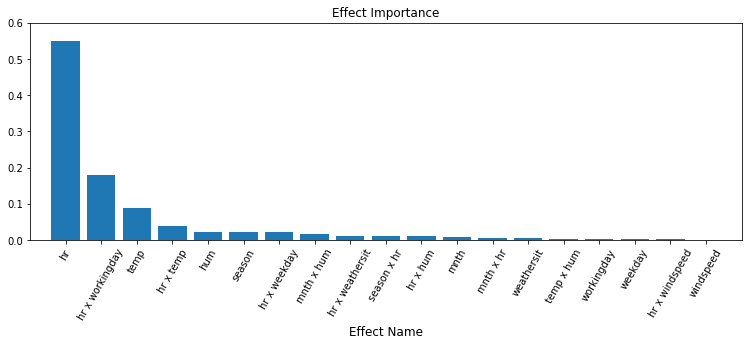

In [19]:
## effect importance 
model.show_effect_importance()

### Local Explain

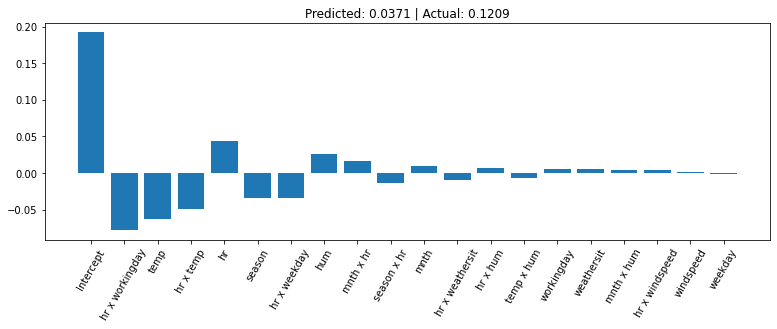

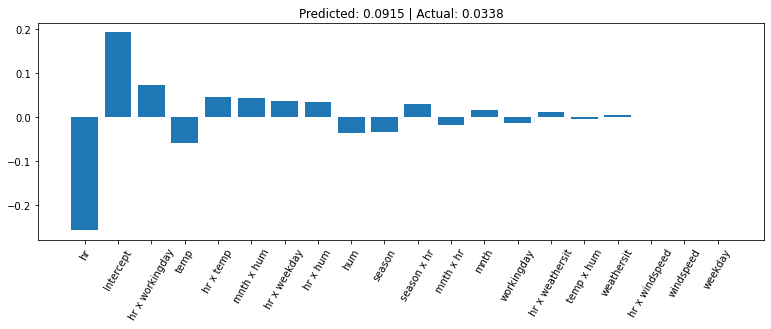

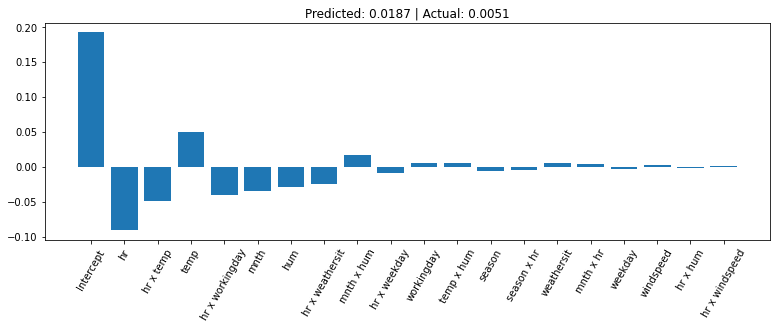

In [20]:
## explain single sample 
model.show_local_explain(train_x[:3], train_y[:3])